In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [2]:
plt.rcParams['font.family'] = 'sans-serif'

# Helper functions

In [3]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [4]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[1:-1] = smoothed[1:-1]
    return vals

In [5]:
def get_df(base, z, pfiles, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': [],
        'model_iter': []}
    for pickle_file in pfiles:
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_score = results['valid_score']
        valid_steps = results['valid_steps_per_ep']
        episode = results['episode']
        model = results['model']
        step = results['step']
        for i in range(len(valid_score)):
            if valid_score[i] == None: continue
            data['valid_score'].append(valid_score[i])
            data['valid_steps'].append(valid_steps[i])
            data['dims'].append(z)
            data['episode'].append(episode[i])
            _model = model[i].split(base+'_')[-1]
            data['model'].append(_model)
            data['z'].append(z)
            data['step'].append(step[i])
            data['model_iter'].append(results['model_iter'][i])
    df = pd.DataFrame(data)
    return df

In [6]:
def find_model_directories(directory_path, model):
    all_files_dirs = os.listdir(directory_path)
    pattern = f'\\b{model}(\\d*)\\b'  # Using word boundaries to ensure complete matches
    matches = [re.search(pattern, item) for item in all_files_dirs]
    
    # Filter out None values (i.e., items that didn't match) and return a list of tuples
    return [(match.group(0), int(match.group(1)) if match.group(1) else None) for match in matches if match]

# Initial Gridworld Experiment

In [7]:
base = 'new_gridworld8x8_shuffobs'
net_yaml = 'dm'
z = 11

In [8]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

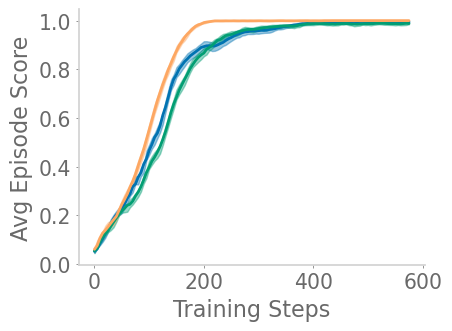

In [9]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf0', 'entro0', 'g0_-2_entro-1']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    
    smooth_n = 5
    means = smooth(episodes, means, smooth_n)
    mean_lowerbound = smooth(episodes, mean_lowerbound)
    mean_upperbound = smooth(episodes, mean_upperbound)
        
    ax.plot(episodes[:-smooth_n], means[:-smooth_n], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
        mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Testing $\gamma$ transfer

In [40]:
base = 'frozentransfer_new_gridworld8x8_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [41]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

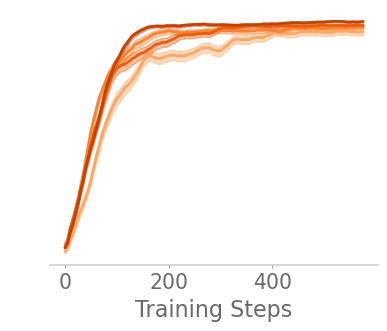

In [43]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.65, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    smooth_n = 5
    means = smooth(episodes, means, smooth_n)
    sems = smooth(episodes, sems, smooth_n)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(
        episodes[:-smooth_n], means[:-smooth_n], label=model,
        color=colors[_idx])
    ax.fill_between(
        episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
        mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
plt.xlabel('Training Steps')
plt.xticks([0, 200, 400])
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

In [44]:
base = 'new_gridworld8x8_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [45]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

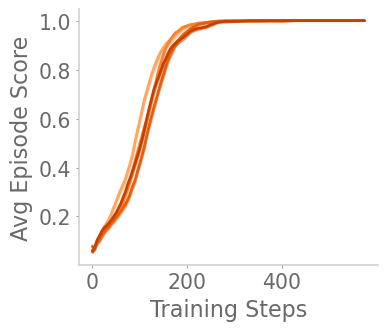

In [46]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.65, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    
    smooth_n = 5
    means = smooth(episodes, means, smooth_n)
    sems = smooth(episodes, sems, smooth_n)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(
        episodes[:-smooth_n], means[:-smooth_n],
        label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
        mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.xticks([0, 200, 400])
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Modifying epsilon

In [7]:
base = 'new_gridworld8x8_eps0.1_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [8]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

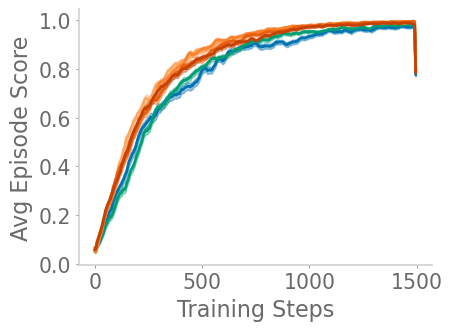

In [9]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf0', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = smooth(episodes, means, 5)
    sems = smooth(episodes, sems, 5)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Modifying epsilon to test goal transfer for $\gamma$

In [84]:
base = 'frozenrandomtransfer_new_gridworld8x8_eps0.1_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [85]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

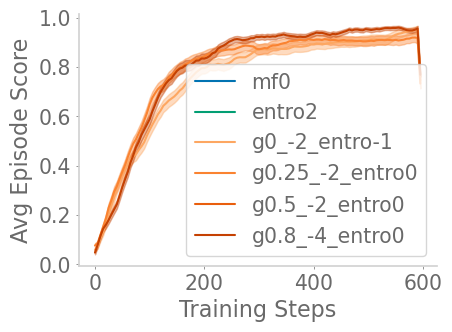

In [86]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf0', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    #np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = smooth(episodes, means, 5)
    sems = smooth(episodes, sems, 5)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.legend()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Modifying transitions to test transfer for $\gamma$

In [19]:
base = 'transitionreval_new_gridworld8x8_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [20]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

mf
Mean: nan, SEM: nan for 0 vals
entro2
Mean: 0.8711111111111111, SEM: 0.01609879112970109 for 225 vals
g0_-2_entro-1
Mean: 0.7488888888888889, SEM: 0.019841746026031885 for 225 vals
g0.25_-2_entro0
Mean: 0.8488888888888889, SEM: 0.016024672335395507 for 225 vals
g0.5_-2_entro0
Mean: 0.8346666666666667, SEM: 0.016790965068646527 for 225 vals
g0.8_-4_entro0
Mean: 0.9204444444444445, SEM: 0.01047100641336075 for 225 vals


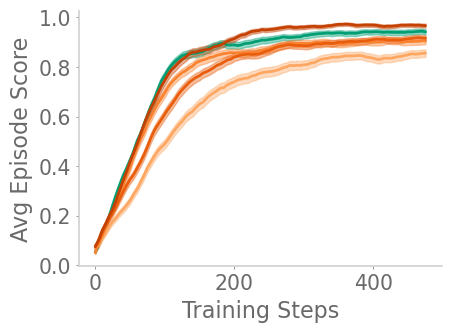

In [22]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    #np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        if ep == 200:
            print(model)
            print(f'Mean: {np.mean(vals)}, SEM: {sem(vals)} for {len(vals)} vals')
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    smooth_n = 5
    means = smooth(episodes, means, smooth_n)
    sems = smooth(episodes, sems, smooth_n)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-smooth_n], means[:-smooth_n], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
        mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

In [23]:
base = 'transitionreval_new_gridworld8x8_eps0.4_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [24]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

mf
Mean: nan, SEM: nan for 0 vals
entro2
Mean: 0.92, SEM: 0.011338934190276817 for 225 vals
g0_-2_entro-1
Mean: 0.6457777777777778, SEM: 0.02079686755683093 for 225 vals
g0.25_-2_entro0
Mean: 0.7435555555555556, SEM: 0.019289541719623264 for 225 vals
g0.5_-2_entro0
Mean: 0.7528888888888889, SEM: 0.019179924101418003 for 225 vals
g0.8_-4_entro0
Mean: 0.7817777777777778, SEM: 0.01814584263511264 for 225 vals


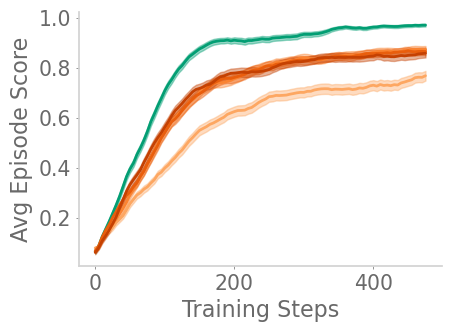

In [25]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    #np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        if ep == 200:
            print(model)
            print(f'Mean: {np.mean(vals)}, SEM: {sem(vals)} for {len(vals)} vals')
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    smooth_n = 5
    means = smooth(episodes, means, smooth_n)
    sems = smooth(episodes, sems, smooth_n)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-smooth_n], means[:-smooth_n], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
        mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [197]:
base = 'gridworld8x8_largeencoder'
net_yaml = 'dm_large_encoder'
z = 6

In [198]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [199]:
np.unique(df['model'])

array(['entro-1', 'entro1', 'entro_0', 'g0.25_-3_entro-1',
       'g0.25_-3_entro0', 'g0.5_-3_entro-1', 'g0.5_-3_entro0',
       'g0.8_-4_entro-1', 'g0.8_-4_entro0', 'g0_-2_entro-1',
       'g0_-2_entro0'], dtype=object)

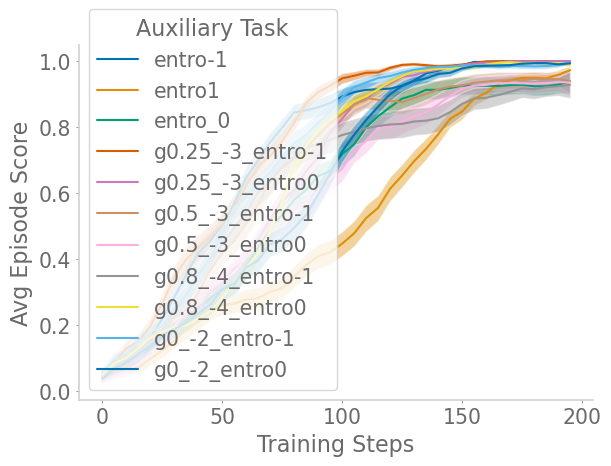

In [200]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(new_df['model'])
    #['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']
    #['mf_2', 'mf_-1', 'mf', 'mf_1', 'mf_2', 'mf_3']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model)#, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4#, color=colors[_idx]
        )
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [6]:
base = 'new_altT_eps0.4_tlen9_mlen5'
net_yaml = 'dm'
z = 24

In [7]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [8]:
np.unique(df['model'])

array(['g0_-2_entro-2'], dtype=object)

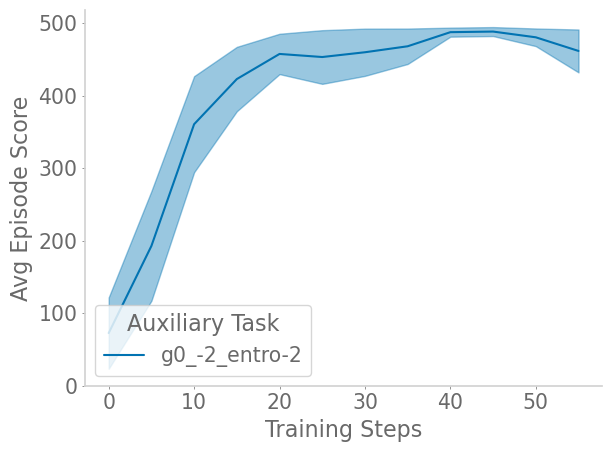

In [9]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [12]:
base = 'poorttask'
net_yaml = 'dm'
z = 32

In [13]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [14]:
np.unique(df['model'])

array(['mf0'], dtype=object)

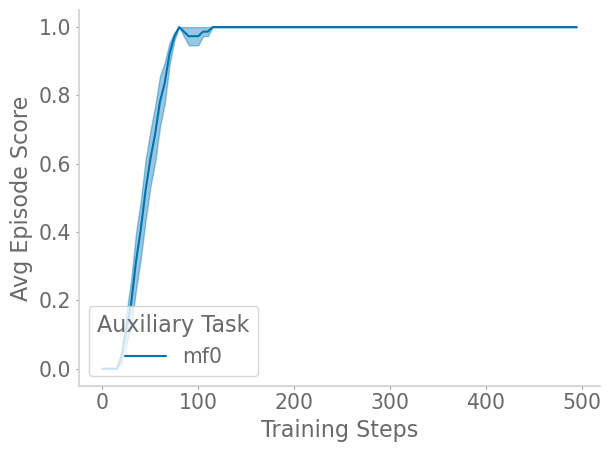

In [15]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx]
        )
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()